In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from torchvision import datasets
from torch.autograd import Variable
from torchvision import models
from skimage.util import montage
import os
import cv2 
import random
import matplotlib.pyplot as plt 
import torch.optim as optim
from PIL import Image
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import glob
import shutil
import numpy as np
from torchvision.models import vgg19_bn
import numpy as np
import seaborn as sns

#mport matplotlib.pyplot as pltimport numpy as np
import torch





random.seed(0)

log_dir = "~/logs"
writer = SummaryWriter(log_dir)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

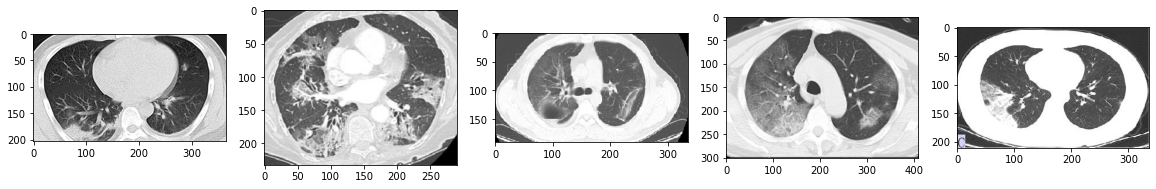

In [2]:
covid_files_path = 'images-processed-original/CT_COVID/'
covid_files      = [os.path.join(covid_files_path, x) for x in os.listdir(covid_files_path)]
covid_images    =  [cv2.imread(x) for x in random.sample(covid_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(covid_images):
    plt.subplot(len(covid_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [3]:
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

In [4]:
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, classes, covid_files, non_covid_files, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.files_path = [non_covid_files, covid_files]
        self.image_list = []

        # read the files from data split text files
        covid_files = read_txt(covid_files)
        non_covid_files = read_txt(non_covid_files)

        # combine the positive and negative files into a cummulative files list
        for cls_index in range(len(self.classes)):
            
            class_files = [[os.path.join(self.root_dir, self.classes[cls_index], x), cls_index] \
                            for x in read_txt(self.files_path[cls_index])]
            self.image_list += class_files
                
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        path = self.image_list[idx][0]
        
        # Read the image
        image = Image.open(path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)

        label = int(self.image_list[idx][1])

        data = {'img':   image,
                'label': label,
                'paths' : path}

        return data

In [5]:

normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])
train_transformer = transforms.Compose([
    transforms.Resize(256),  
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [6]:
batchsize =  16 #melhor ate agora 16
#Images-processed
trainset = CovidCTDataset(root_dir='images-processed-original/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='Data-split/COVID/trainCT_COVID.txt',
                          non_covid_files='Data-split/NonCOVID/trainCT_NonCOVID.txt',
                          transform= train_transformer)
valset = CovidCTDataset(root_dir='images-processed-original/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='Data-split/COVID/valCT_COVID.txt',
                          non_covid_files = 'Data-split/NonCOVID/valCT_NonCOVID.txt',
                          transform= val_transformer)
testset = CovidCTDataset(root_dir='images-processed-original/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='Data-split/COVID/testCT_COVID.txt',
                          non_covid_files='Data-split/NonCOVID/testCT_NonCOVID.txt',
                          transform= val_transformer)

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

In [7]:
def compute_metrics(model, test_loader, plot_roc_curve = False):
    
    model.eval()
    
    val_loss = 0
    val_correct = 0
    
    criterion = nn.CrossEntropyLoss()
    
    score_list   = torch.Tensor([]).to(device)
    pred_list    = torch.Tensor([]).to(device).long()
    target_list  = torch.Tensor([]).to(device).long()
    path_list    = []

    
    for iter_num, data in enumerate(test_loader):
        
        # Convert image data into single channel data
        image, target = data['img'].to(device), data['label'].to(device)
        paths = data['paths']
        path_list.extend(paths)
        
        # Compute the loss
        with torch.no_grad():
            output = model(image)
        
        # Log loss
        val_loss += criterion(output, target.long()).item()

        
        # Calculate the number of correctly classified examples
        pred = output.argmax(dim=1, keepdim=True)
        val_correct += pred.eq(target.long().view_as(pred)).sum().item()
        
        # Bookkeeping 
        score_list   = torch.cat([score_list, nn.Softmax(dim = 1)(output)[:,1].squeeze()])
        pred_list    = torch.cat([pred_list, pred.squeeze()])
        target_list  = torch.cat([target_list, target.squeeze()])
        
    
    classification_metrics = classification_report(target_list.tolist(), pred_list.tolist(),
                                                  target_names = ['CT_NonCOVID', 'CT_COVID'],
                                                  output_dict= True)
    
    
    # sensitivity is the recall of the positive class
    sensitivity = classification_metrics['CT_COVID']['recall']
    
    # specificity is the recall of the negative class 
    specificity = classification_metrics['CT_NonCOVID']['recall']
    
    # accuracy
    accuracy = classification_metrics['accuracy']
    
    # confusion matrix
    conf_matrix = confusion_matrix(target_list.tolist(), pred_list.tolist())
    
    # roc score
    roc_score = roc_auc_score(target_list.tolist(), score_list.tolist())
    
    # plot the roc curve
    if plot_roc_curve:
        fpr, tpr, _ = roc_curve(target_list.tolist(), score_list.tolist())
        plt.plot(fpr, tpr, label = "Area under ROC = {:.4f}".format(roc_score))
        plt.legend(loc = 'best')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    
    # put together values
    metrics_dict = {"Accuracy": accuracy,
                    "Sensitivity": sensitivity,
                    "Specificity": specificity,
                    "Roc_score"  : roc_score, 
                    "Confusion Matrix": conf_matrix,
                    "Validation Loss": val_loss / len(test_loader),
                    "score_list":  score_list.tolist(),
                    "pred_list": pred_list.tolist(),
                    "target_list": target_list.tolist(),
                    "paths": path_list}
    
    
    return metrics_dict

In [8]:
#model = vgg19_bn(pretrained=True)
import torchvision.models as models
model = models.densenet169(pretrained=True).cuda()
#model.classifier[6] = nn.Linear(4096, 2)
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
learning_rate = 0.01
optimizer     = optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)


In [10]:
class EarlyStopping(object):
    def __init__(self, patience = 8):
        super(EarlyStopping, self).__init__()
        self.patience = patience
        self.previous_loss = int(1e8)
        self.previous_accuracy = 0
        self.init = False
        self.accuracy_decrease_iters = 0
        self.loss_increase_iters = 0
        self.best_running_accuracy = 0
        self.best_running_loss = int(1e7)
    
    def add_data(self, model, loss, accuracy):
        
        # compute moving average
        if not self.init:
            running_loss = loss
            running_accuracy = accuracy 
            self.init = True
        
        else:
            running_loss = 0.2 * loss + 0.8 * self.previous_loss
            running_accuracy = 0.2 * accuracy + 0.8 * self.previous_accuracy
        
        # check if running accuracy has improved beyond the best running accuracy recorded so far
        if running_accuracy < self.best_running_accuracy:
            self.accuracy_decrease_iters += 1
        else:
            self.best_running_accuracy = running_accuracy
            self.accuracy_decrease_iters = 0
        
        # check if the running loss has decreased from the best running loss recorded so far
        if running_loss > self.best_running_loss:
            self.loss_increase_iters += 1
        else:
            self.best_running_loss = running_loss
            self.loss_increase_iters = 0
        
        # log the current accuracy and loss
        self.previous_accuracy = running_accuracy
        self.previous_loss = running_loss        
        
    
    def stop(self):
        
        # compute thresholds
        accuracy_threshold = self.accuracy_decrease_iters > self.patience
        loss_threshold = self.loss_increase_iters > self.patience
        
        
        # return codes corresponding to exhuaustion of patience for either accuracy or loss 
        # or both of them
        if accuracy_threshold and loss_threshold:
            return 1
        
        if accuracy_threshold:
            return 2
        
        if loss_threshold:
            return 3
        
        
        return 0
    
    def reset(self):
        # reset
        self.accuracy_decrease_iters = 0
        self.loss_increase_iters = 0
    
early_stopper = EarlyStopping(patience = 5)

In [11]:
best_model = model
best_val_score = 0

criterion = nn.CrossEntropyLoss()

for epoch in range(60):

    model.train()    
    train_loss = 0
    train_correct = 0
    
    for iter_num, data in enumerate(train_loader):
        image, target = data['img'].to(device), data['label'].to(device)     
        x = torch.ones((64, 3, 224, 224))
        model.cuda()
        output = model(image)
        loss = criterion(output, target.long()) / 8
         # Log loss
        train_loss += loss.item()
        loss.backward()

        # Perform gradient udpate
        if iter_num % 8 == 0:
            optimizer.step()
            optimizer.zero_grad()
            

        # Calculate the number of correctly classified examples
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
        
    
    # Compute and print the performance metrics
    metrics_dict = compute_metrics(model, val_loader)
    print('------------------ Epoch {} Iteration {}--------------------------------------'.format(epoch,
                                                                                                 iter_num))
    print("Accuracy \t {:.3f}".format(metrics_dict['Accuracy']))
    print("Sensitivity \t {:.3f}".format(metrics_dict['Sensitivity']))
    print("Specificity \t {:.3f}".format(metrics_dict['Specificity']))
    print("Area Under ROC \t {:.3f}".format(metrics_dict['Roc_score']))
    print("Val Loss \t {}".format(metrics_dict["Validation Loss"]))
    print("------------------------------------------------------------------------------")
    
    # Save the model with best validation accuracy
    if metrics_dict['Accuracy'] > best_val_score:
        torch.save(model, "best_model_original.pkl")
        best_val_score = metrics_dict['Accuracy']
    
    
    # print the metrics for training data for the epoch
    print('\nTraining Performance Epoch {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))
    
    # log the accuracy and losses in tensorboard
    writer.add_scalars( "Losses", {'Train loss': train_loss / len(train_loader), 'Validation_loss': metrics_dict["Validation Loss"]},
                                   epoch)
    writer.add_scalars( "Accuracies", {"Train Accuracy": 100.0 * train_correct / len(train_loader.dataset),
                                       "Valid Accuracy": 100.0 * metrics_dict["Accuracy"]}, epoch)

    # Add data to the EarlyStopper object
    early_stopper.add_data(model, metrics_dict['Validation Loss'], metrics_dict['Accuracy'])
    
    # If both accuracy and loss are not improving, stop the training
    if early_stopper.stop() == 1:
        break
    
    # if only loss is not improving, lower the learning rate
    if early_stopper.stop() == 2: # para vgg19 usamos 3 
        for param_group in optimizer.param_groups:
            learning_rate *= 0.1
            param_group['lr'] = learning_rate
            print('Updating the learning rate to {}'.format(learning_rate))
            early_stopper.reset()
    
    torch.save(model, "modelo_original.pkl")
    torch.save(model, 'modelo_original_pth.pth')


       

------------------ Epoch 0 Iteration 26--------------------------------------
Accuracy 	 0.614
Sensitivity 	 0.150
Specificity 	 1.000
Area Under ROC 	 0.859
Val Loss 	 2.4941616414289456
------------------------------------------------------------------------------

Training Performance Epoch 0: Average loss: 0.0412, Accuracy: 110/425 (26%)

------------------ Epoch 1 Iteration 26--------------------------------------
Accuracy 	 0.693
Sensitivity 	 0.675
Specificity 	 0.708
Area Under ROC 	 0.785
Val Loss 	 0.930078054467837
------------------------------------------------------------------------------

Training Performance Epoch 1: Average loss: 0.0040, Accuracy: 335/425 (79%)

------------------ Epoch 2 Iteration 26--------------------------------------
Accuracy 	 0.830
Sensitivity 	 0.625
Specificity 	 1.000
Area Under ROC 	 0.908
Val Loss 	 0.5865666028112173
------------------------------------------------------------------------------

Training Performance Epoch 2: Average loss:

------------------ Epoch 24 Iteration 26--------------------------------------
Accuracy 	 0.795
Sensitivity 	 0.800
Specificity 	 0.792
Area Under ROC 	 0.882
Val Loss 	 0.877433285738031
------------------------------------------------------------------------------

Training Performance Epoch 24: Average loss: 0.0003, Accuracy: 420/425 (99%)



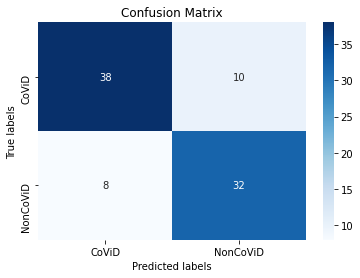

In [12]:

conf_matrix = metrics_dict["Confusion Matrix"]
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, cmap = 'Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['CoViD', 'NonCoViD']); ax.yaxis.set_ticklabels(['CoViD', 'NonCoViD']);
        

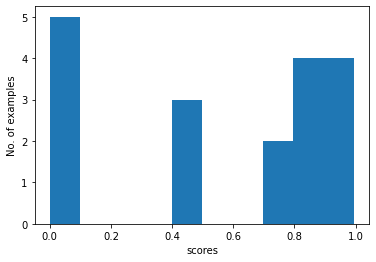

In [13]:
targets = np.array(metrics_dict['target_list'])
preds   = np.array(metrics_dict['pred_list'])
scores  = np.array(metrics_dict['score_list'])


misclassified_indexes = np.nonzero(targets != preds)
misclassified_scores = scores[misclassified_indexes[0]]

# plot the historgram of misclassified scores
plt.hist(misclassified_scores)
plt.xlabel("scores")
plt.ylabel("No. of examples")
plt.show()

D:\anaconda3\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
D:\anaconda3\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
D:\anaconda3\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.d

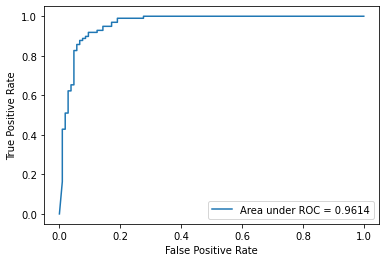

------------------- Test Performance --------------------------------------
Accuracy 	 0.882
Sensitivity 	 0.990
Specificity 	 0.781
Area Under ROC 	 0.961
-----------------------------------------------------------------------------


In [14]:
model = torch.load("pretrained_covid_model.pkl" )

metrics_dict = compute_metrics(model, test_loader, plot_roc_curve = True)
print('------------------- Test Performance --------------------------------------')
print("Accuracy \t {:.3f}".format(metrics_dict['Accuracy']))
print("Sensitivity \t {:.3f}".format(metrics_dict['Sensitivity']))
print("Specificity \t {:.3f}".format(metrics_dict['Specificity']))
print("Area Under ROC \t {:.3f}".format(metrics_dict['Roc_score']))
print("-----------------------------------------------------------------------------")

In [15]:
data_dir = 'images-processed-original'

normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])
test_transforms = transforms.Compose([
    transforms.Resize(256),  
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])



In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('modelo_original_pth.pth')
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [17]:
#def predict_image(image):
   # image_tensor = test_transforms(image).float()
   # print("IMAGE TENSOR: ", image_tensor)
   # image_tensor = image_tensor.unsqueeze_(0)
   # print("IMAGE TENSOR UNSQUEEZE: ", image_tensor)
   # input = Variable(image_tensor)
   # input = input.to(device)
   # output = model(input)
   # index = output.data.cpu().numpy().argmax()
   # return index
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [18]:
#def get_random_images(num):
 #   data = datasets.ImageFolder(data_dir, transform=test_transforms)
  #  classes = data.classes
  #  print("CLASSES:", classes)
  #  indices = list(range(len(data)))
  #  print(indices)
  #  np.random.shuffle(indices)
  #  idx = indices[:num]
  ###  print("INDICE: ", idx)
   # from torch.utils.data.sampler import SubsetRandomSampler
   # sampler = SubsetRandomSampler(idx)
   # print("SAMPLER: ", sampler)
   # loader = torch.utils.data.DataLoader(data, 
   #                sampler=sampler, batch_size=num)
   # dataiter = iter(loader)
   # return images, labels
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels
    
    

RES DEPOIS:  NON_COVID
RES DEPOIS:  COVID
RES DEPOIS:  COVID


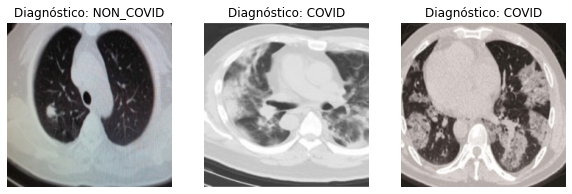

In [48]:
#to_pil = transforms.ToPILImage()
#images, labels = get_random_images(5)
#fig=plt.figure(figsize=(10,10))
#for ii in range(len(images)):
    #image = to_pil(images[ii])
    #index = predict_image(image)
    #sub = fig.add_subplot(1, len(images), ii+1)
    #res = int(labels[ii]) == index
   # sub.set_title(str(classes[index]) + ":" + str(res))
  #  plt.axis('off')
 #   plt.imshow(image)
#plt.show()
to_pil = transforms.ToPILImage()
images, labels = get_random_images(3)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    #print(labels[ii])
    res = int(labels[ii]) == index
    #print("RES ANTES: ", res)
    if (str(res) == "True"):
        res = "COVID"
        plt.imshow(image)
    if (str(res) == "False"):
        res = "NON_COVID"
        plt.imshow(image)
    print("RES DEPOIS: ", res)
    #sub.set_title(str(labels[index]) + ":" + str(res))
    sub.set_title("Diagnóstico: " + str(res))
    plt.axis('off')    
plt.show()


In [20]:
from gradcam import *

def do_grad_cam(path):

    # Initialise the grad cam object. 
    # we use model.features as the feature extractor and use the layer no. 35 for gradients. 
    grad_cam = GradCam(model=model, feature_module=model.features, \
                           target_layer_names=["35"], use_cuda=True)

    # read in the image, and prepare it for the network
    orig_im = cv2.imread(path)
    img = Image.fromarray(orig_im)
    inp = val_transformer(img).unsqueeze(0)

    # main inference
    mask = grad_cam(inp, None)

    # create the heatmap 
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    
    #add the heatmap to the original image
    cam = heatmap + np.float32(cv2.resize(orig_im, (224,224))/255.)
    cam = cam / np.max(cam)
    
    # BGR -> RGB since OpenCV operates with BGR values. 
    cam = cam[:,:,::-1] 
    
    return cam

In [21]:

true_positives = np.logical_and(preds == 1, targets == 1)
true_positives = np.logical_and(true_positives, scores > 0.9)
true_positives_indices = np.nonzero(true_positives)
true_positives_paths = [metrics_dict['paths'][i] for i in true_positives_indices[0]]

true_negatives = np.logical_and(preds == 0, targets == 1)
true_negatives = np.logical_and(true_negatives, scores < 0.2)
true_negatives_indices = np.nonzero(true_negatives)
true_negatives_paths = [metrics_dict['paths'][i] for i in true_negatives_indices[0]]

true_positive_images    =  [do_grad_cam(x) for x in random.sample(true_positives_paths, 10)]
true_negative_images    =  [do_grad_cam(x) for x in random.sample(true_negatives_paths, 10)]
#print(preds[106])
#print(preds[133])
#print(preds[142])
#print(preds[153])
#print(preds[163])
#print(preds[164])
#print(preds[167])
#print(preds[174])
##print(preds[196])
#print(preds[198])
#print(preds[199])
#print(preds[201])
#rint(preds[202])

#print(preds[105])
#print(preds[107])
#print(preds[108])
#print(preds[110])
#print(preds[111])
#print(preds[113])
#print("pulando linha \n")


print ("POSITIVOS")
plt.figure(figsize=(30,15))
columns = 5
print(true_positives_paths)
for i, image in enumerate(true_positive_images):
    print(preds[i])
    plt.subplot(len(true_positive_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

    
   

RuntimeError: mat1 dim 1 must match mat2 dim 0